In [18]:
import argparse
import logging
import pathlib
import sys

import numpy as np
import scipy.constants as constants
import scipy.linalg as linalg
import scipy.stats as stats

import numpy as np
import scipy.signal.windows as windows
import skimage.util as skutil

# import imot_tools.phased_array as phased_array
from trainer.utils import draw_map, steering_operator, get_xyz, get_field, cart2pol, pol2cart
# import imot_tools.math.stat as stat

def steering_operator_og(XYZ, R, wl):
    r"""
    Steering matrix.

    Parameters
    ----------
    XYZ : :py:class:`~numpy.ndarray`
        (3, N_antenna) Cartesian array geometry.
    R : :py:class:`~numpy.ndarray`
        (3, N_px) Cartesian grid points in :math:`\mathbb{S}^{2}`.
    wl : float
        Wavelength [m].

    Returns
    -------
    A : :py:class:`~numpy.ndarray`
        (N_antenna, N_px) steering matrix.

    Notes
    -----
    The steering matrix is defined as:

    .. math:: {\bf{A}} = \exp \left( -j \frac{2 \pi}{\lambda} {\bf{P}}^{T} {\bf{R}} \right),

    where :math:`{\bf{P}} \in \mathbb{R}^{3 \times N_{\text{antenna}}}` and
    :math:`{\bf{R}} \in \mathbb{R}^{3 \times N_{\text{px}}}`.
    """
    if wl <= 0:
        raise ValueError("Parameter[wl] must be positive.")

    scale = 2 * np.pi / wl
    A = np.exp((-1j * scale * XYZ.T) @ R)
    return A


class Wishart():
    """
    `Wishart <https://en.wikipedia.org/wiki/Wishart_distribution>`_ distribution.
    """
    def __init__(self, V, n):
        """
        Parameters
        ----------
        V : :py:class:`~numpy.ndarray`
            (p, p) positive-semidefinite scale matrix.
        n : int
            degrees of freedom.
        """
        super().__init__()

        V = np.array(V)
        p = len(V)


        self._V = V
        self._p = p
        self._n = n

        Vq = linalg.sqrtm(V)
        _, R = linalg.qr(Vq)
        self._L = R.conj().T

    def __call__(self, N_sample=1):
        """
        Generate random samples.

        Parameters
        ----------
        N_sample : int
            Number of samples to generate.

        Returns
        -------
        x : :py:class:`~numpy.ndarray`
            (N_sample, p, p) samples.

        Notes
        -----
        The Wishart estimate is obtained using the `Bartlett Decomposition`_.

        .. _Bartlett Decomposition: https://en.wikipedia.org/wiki/Wishart_distribution#Bartlett_decomposition
        """
        if N_sample < 1:
            raise ValueError("Parameter[N_sample] must be positive.")

        A = np.zeros((N_sample, self._p, self._p))

        diag_idx = np.diag_indices(self._p)
        df = self._n * np.ones((N_sample, 1)) - np.arange(self._p)
        A[:, diag_idx[0], diag_idx[1]] = np.sqrt(stats.chi2.rvs(df=df))

        tril_idx = np.tril_indices(self._p, k=-1)
        size = (N_sample, self._p * (self._p - 1) // 2)
        A[:, tril_idx[0], tril_idx[1]] = stats.norm.rvs(size=size)

        W = self._L @ A
        X = W @ W.conj().transpose(0, 2, 1)
        return X

    
class VisibilityGenerator:
    """
    Generate synthetic visibility matrices using the Wishart distribution.
    """

    def __init__(self, T, fs, SNR):
        """
        Parameters
        ----------
        T : float
            Integration time [s].
        fs : float
            Sampling rate [Hz].
        SNR : float
            Signal-to-Noise-Ratio (dB).
        """
        if T <= 0:
            raise ValueError('Parameter[T] must be positive.')
        if fs <= 0:
            raise ValueError('Parameter[fs] must be positive.')

        self._N_sample = int(T * fs) + 1
        self._SNR = 10 ** (SNR / 10)

    def __call__(self, s_I, s_xyz, wl):
        """
        Compute visibility matrix.

        Parameters
        ----------
        XYZ : :py:class:`~numpy.ndarray`
            (3, N_antenna) Cartesian instrument geometry.
        wl : float
            Wave-length >= 0 [m].
        sky_model : :py:class:`~deepwave.tools.data_gen.source.SkyModel`
            Source model.

        Returns
        -------
        S : :py:class:`~numpy.ndarray`
            (N_antenna, N_antenna) visibility matrix.
        """
        if wl <= 0:
            raise ValueError('Parameter[wl] must be positive.')

        N_antenna = 32
        xyz = get_xyz()
        XYZ = np.array(xyz).T
        A = steering_operator_og(XYZ, s_xyz, wl)
        print(s_I)
        print(A.shape)
#         S_sky = (A * s_I) @ A.conj().T
        S_sky = (A) @ A.conj().T
        print(S_sky.shape)

        noise_var = np.sum(s_I) / (2 * self._SNR)
        S_noise = noise_var * np.eye(N_antenna)
        print(S_noise.shape)
        wishart = Wishart(V=S_sky + S_noise, n=self._N_sample)
        S = wishart()[0] / self._N_sample
        return S


class TimeSeriesGenerator:
    """
    Generate synthetic baseband-equivalent time-series.
    """

    def __init__(self, fs, SNR):
        """
        Parameters
        ----------
        fs : float
            Sampling rate [Hz].
        SNR : float
            Signal-to-Noise-Ratio (dB).
        """
        if fs <= 0:
            raise ValueError('Parameter[fs] must be positive.')
        self._fs = fs

        self._SNR = 10 ** (SNR / 10)

    def __call__(self, XYZ, wl, sky_model, T):
        """
        Compute time series.

        Parameters
        ----------
        XYZ : :py:class:`~numpy.ndarray`
            (3, N_antenna) Cartesian instrument geometry.
        wl : float
            Wave-length >= 0 [m].
        sky_model : :py:class:`~deepwave.tools.data_gen.source.SkyModel`
            Source model.
        T : float
            Signal duration [s].

        Returns
        -------
        ts : :py:class:`~numpy.ndarray`
            (N_sample, N_channel) baseband-equivalent time series.
        """
        if wl <= 0:
            raise ValueError('Parameter[wl] must be positive.')
        if not (isinstance(T, float) and (T > 0)):
            raise ValueError('Parameter[T] must be positive.')
        N_sample, N_channel = int(T * self._fs) + 1, XYZ.shape[1]

        s_xyz = sky_model.xyz
        s_I = sky_model.intensity
        N_src = s_I.shape[0]

        A = phased_array.steering_operator(XYZ, s_xyz, wl)
        s_eps = (np.sqrt(s_I / 2).reshape(N_src, 1) *
                 (np.random.randn(N_src, N_sample) +
                  1j * np.random.randn(N_src, N_sample)))
        s_ts = A @ s_eps

        noise_var = np.sum(s_I) / (2 * self._SNR)
        n_ts = np.sqrt(noise_var) * (np.random.randn(N_channel, N_sample) +
                                     1j * np.random.randn(N_channel, N_sample))

        ts = s_ts.T + n_ts.T
        return ts


class TimeSeries:
    """
    Time-Series representation.
    """

    def __init__(self, data, rate):
        """
        Parameters
        ----------
        data : :py:class:`~numpy.ndarray`
            (N_sample, N_channel) time series (real-valued)
        rate : int
            Sample Rate [Hz]
        """
        if not (isinstance(data, np.ndarray) and
                (data.ndim == 2) and
                np.issubdtype(data.dtype, np.floating)):
            raise ValueError('Parameter[data] must be a (N_sample, N_channel) real-valued.')
        self._data = data

        if not (isinstance(rate, int) and (rate > 0)):
            raise ValueError('Parameter[rate] must be positive.')
        self._rate = rate

    @property
    def data(self):
        """
        Returns
        -------
        data : :py:class:`~numpy.ndarray`
            (N_sample, N_channel) time series (real-valued)
        """
        return self._data

    @property
    def rate(self):
        """
        Returns
        -------
        rate : int
            Sample Rate [Hz]
        """
        return self._rate

    def extract_visibilities(self, T, fc, bw, alpha):
        """
        Transform time-series to visibility matrices.

        Parameters
        ----------
        T : float
            Integration time [s].
        fc : float
            Center frequency [Hz] around which visibility matrices are formed.
        bw : float
            Double-wide bandwidth [Hz] of the visibility matrix.
        alpha : float
            Shape parameter of the Tukey window, representing the fraction of
            the window inside the cosine tapered region. If zero, the Tukey
            window is equivalent to a rectangular window. If one, the Tukey
            window is equivalent to a Hann window.

        Returns
        -------
        S : :py:class:`~numpy.ndarray`
            (N_slot, N_channel, N_channel) visibility matrices (complex-valued).
        """
        if not (isinstance(T, float) and (T > 0)):
            raise ValueError('Parameter[T] must be positive.')

        if not (isinstance(fc, float) and (fc > 0)):
            raise ValueError('Parameter[fc] must be positive.')

        if not (isinstance(bw, float) and (bw > 0)):
            raise ValueError('Parameter[bw] must be positive.')

        if not (isinstance(alpha, float) and (0 <= alpha <= 1)):
            raise ValueError('Parameter[alpha] must be in [0, 1].')

        if not (bw < 2 * fc < self._rate - bw):
            raise ValueError('Interested frequency range too broad given sampling rate.')

        N_stft_sample = int(self._rate * T)
        if N_stft_sample == 0:
            raise ValueError('Not enough samples per time frame.')
        # print(f'Samples per STFT: {N_stft_sample}')

        N_sample = (self._data.shape[0] // N_stft_sample) * N_stft_sample
        N_channel = self._data.shape[1]
        stf_data = (skutil.view_as_blocks(self._data[:N_sample], (N_stft_sample, N_channel))
                    .squeeze(axis=1))  # (N_stf, N_stft_sample, N_channel)

        window = windows.tukey(M=N_stft_sample, alpha=alpha, sym=True).reshape(1, -1, 1)
        stf_win_data = stf_data * window  # (N_stf, N_stft_sample, N_channel)
        N_stf = stf_win_data.shape[0]

        stft_data = np.fft.fft(stf_win_data, axis=1)  # (N_stf, N_stft_sample, N_channel)
        # Find frequency channels to average together.
        idx_start = int((fc - 0.5 * bw) * N_stft_sample / self._rate)
        idx_end = int((fc + 0.5 * bw) * N_stft_sample / self._rate)
        # print(f'Spectrum start index: {idx_start}/{N_stft_sample}')
        # print(f'Spectrum end index: {idx_end}/{N_stft_sample}')
        collapsed_spectrum = np.sum(stft_data[:, idx_start:idx_end + 1, :], axis=1)

        # Don't understand yet why conj() on first term?
        S = (collapsed_spectrum.reshape(N_stf, -1, 1).conj() *
             collapsed_spectrum.reshape(N_stf, 1, -1))
        return S

In [17]:
%load_ext autoreload
%autoreload 2

In [19]:
# ############################################################################
# apgd.py
# =======
# Author : Sepand KASHANI [sepand.kashani@epfl.ch]
# ############################################################################

"""
Accelerated Proximal Gradient Descent (APGD) Solver.
"""

import time

import numpy as np
import pyunlocbox as opt
from pyunlocbox.functions import dummy

import scipy.sparse.linalg as splinalg


def eighMax(A):
    r"""
    Evaluate :math:`\mu_{\max}(\bbB)` with

    :math:

    B = (\overline{\bbA} \circ \bbA)^{H} (\overline{\bbA} \circ \bbA)

    Uses a matrix-free formulation of the Lanczos algorithm.

    Parameters
    ----------
    A : :py:class:`~numpy.ndarray`
        (M, N) array.

    Returns
    -------
    D_max : float
        Leading eigenvalue of `B`.
    """
    if A.ndim != 2:
        raise ValueError('Parameter[A] has wrong dimensions.')

    def matvec(v):
        r"""
        Parameters
        ----------
        v : :py:class:`~numpy.ndarray`
            (N,) or (N, 1) array

        Returns
        -------
        w : :py:class:`~numpy.ndarray`
            (N,) array containing :math:`\bbB \bbv`
        """
        v = v.reshape(-1)

        C = (A * v) @ A.conj().T
        D = C @ A
        w = np.sum(A.conj() * D, axis=0).real
        return w

    M, N = A.shape
    B = splinalg.LinearOperator(shape=(N, N),
                                matvec=matvec,
                                dtype=np.float64)
    D_max = splinalg.eigsh(B, k=1, which='LM', return_eigenvectors=False)
    return D_max[0]


class l2_loss(opt.functions.func):
    r"""
    L2 loss function of the form

    :math:

    f(\bbx; \bbSigma, \bbA) = \norm{\bbSigma - \bbA \diag(\bbx) \bbA^{H}}{F}^{2}
    """

    def __init__(self, S, A):
        """
        Parameters
        ----------
        S : :py:class:`~numpy.ndarray`
            (M, M) visibility matrix.
        A : :py:class:`~numpy.ndarray`
            (M, N) system steering matrix.
        """
        M, N = A.shape
        if not ((S.shape[0] == S.shape[1]) and (S.shape[0] == M)):
            raise ValueError('Parameters[S, A] are inconsistent.')
        if not np.allclose(S, S.conj().T):
            raise ValueError('Parameter[S] must be Hermitian.')

        super().__init__()
        self._S = S.copy()
        self._A = A.copy()

    def _eval(self, x):
        """
        Function evaluation.

        Parameters
        ----------
        x : :py:class:`~numpy.ndarray`
            The evaluation point.

            If `x` is a matrix, the function gets evaluated for each column, as
            if it was a set of independent problems.

        Returns
        -------
        z : float
            The objective function evaluated at `x`.

            If `x` is a matrix, the sum of the objectives is returned.
        """
        if x.ndim == 1:
            x = x.reshape(-1, 1)

        M, N = self._A.shape
        Q = x.shape[1]
        B = ((self._A.reshape(1, M, N) * x.reshape(N, 1, Q).T) @
             self._A.conj().T) - self._S

        z = np.sum(B * B.conj()).real
        return z

    def _grad(self, x):
        """
        Function gradient.

        Parameters
        ----------
        x : :py:class:`~numpy.ndarray`
            The evaluation point.

            If `x` is a matrix, the function gets evaluated for each column, as
            if it was a set of independent problems.

        Returns
        -------
        z : :py:class:`~numpy.ndarray`
            The objective function gradient evaluated for each column of `x`.
        """
        was_1d = (x.ndim == 1)
        if was_1d:
            x = x.reshape(-1, 1)

        M, N = self._A.shape
        Q = x.shape[1]
        B = ((self._A.reshape(1, M, N) * x.reshape(N, 1, Q).T) @
             self._A.conj().T) - self._S

        z = 2 * np.sum(self._A.conj() * (B @ self._A), axis=1).real.T
        if was_1d:
            z = z.reshape(-1)
        return z


class elastic_net_loss(opt.functions.func):
    """
    Elastic-net regularizer.
    """

    def __init__(self, lambda_, gamma):
        r"""
        Parameters
        ----------
        lambda_ : float
            Regularization parameter \ge 0.
        gamma : float
            Linear trade-off between lasso and ridge regularizers.
        """
        if lambda_ < 0:
            raise ValueError('Parameter[lambda_] must be positive.')
        if not (0 <= gamma <= 1):
            raise ValueError('Parameter[gamma] must be in (0, 1).')

        super().__init__()
        self._lambda = lambda_
        self._gamma = gamma

    def _eval(self, x):
        """
        Function evaluation.

        Parameters
        ----------
        x : :py:class:`~numpy.ndarray`
            The evaluation point.

            If `x` is a matrix, the function gets evaluated for each column, as
            if it was a set of independent problems.

        Returns
        -------
        z : float
            The objective function evaluated at `x`.

            If `x` is a matrix, the sum of the objectives is returned.
        """
        if x.ndim == 1:
            x = x.reshape(-1, 1)

        L1_term = self._gamma * np.sum(np.abs(x), axis=0)
        L2_term = (1 - self._gamma) * np.sum(x ** 2, axis=0)

        z = np.sum(self._lambda * (L1_term + L2_term))
        return z

    def _prox(self, x, alpha):
        r"""
        Function proximal operator.

        Parameters
        ----------
        x : :py:class:`~numpy.ndarray`
            The evaluation point.

            If `x` is a matrix, the function gets evaluated for each column, as
            if it was a set of independent problems.

        alpha : float
            Regularization parameter.

        Returns
        -------
        z : :py:class:`~numpy.ndarray`
            The proximal operator evaluated for each column of `x`.

        Notes
        -----
        The proximal operator is given by

        :math:
        \prox_{\alpha g}(\bbx) = \argmin_{\bbu} \frac{1}{2} \norm{\bbx - \bbu}{2}^{2} + \alpha g(\bbu)
        """
        C1 = self._lambda * alpha * self._gamma
        C2 = 2 * self._lambda * alpha * (1 - self._gamma) + 1

        z = np.clip((x - C1) / C2, a_min=0, a_max=None)
        return z


class ground_truth_accel(opt.acceleration.accel):
    r"""
    Acceleration scheme used to evaluate Acoustic Camera ground-truth.

    Highlights
    ----------
    * Chooses GD step size as :math:`1/L_{\grad{f}}`;
    * Implements Nesterov acceleration.
    """

    def __init__(self, d, L, momentum=True):
        """
        Parameters
        ----------
        d : float
            Weight parameter as defined in [1].
        L : float
            Lipschitz constant of the gradient of the smooth function being
            optimized.
        momentum : bool
            If :py:obj:`False`, disable Nesterov acceleration.

        Notes
        -----
        [1] On the Convergence of the Iterates of the "Fast Iterative
            [Shrinkage/Thresholding Algorithm" [Chambolle, Dossal]
        """
        super().__init__()

        if d < 2:
            raise ValueError('Parameter[d] is out of range.')

        self._d = d
        self._step = 1 / L
        self._sol_prev = 0
        self._momentum = momentum

    def _pre(self, functions, x0):
        """
        Pre-processing specific to the acceleration scheme.
        """
        pass

    def _update_step(self, solver, objective, niter):
        """
        Update the step size for the next iteration.

        Parameters
        ----------
        solver : :py:class:`~pyunlocbox.solvers.solver`
            Solver on which to act.
        objective : list(float)
            Evaluations of the objective function since the beginning of the iterative process.
        niter : int
            Current iteration number >= 1.

        Returns
        -------
        step : float
            Updated step size.
        """
        return self._step

    def _update_sol(self, solver, objective, niter):
        """
        Update the solution point for the next iteration.

        Parameters
        ----------
        solver : :py:class:`~pyunlocbox.solvers.solver`
            Solver on which to act.
        objective : list(float)
            Evaluations of the objective function since the beginning of the iterative process.
        niter : int
            Current iteration number >= 1.

        Returns
        -------
        step : :py:class:`~numpy.ndarray`
            (N,) updated solution point.
        """
        if self._momentum is True:
            step = (niter - 1) / (niter + self._d)
            sol = solver.sol + step * (solver.sol - self._sol_prev)
        else:
            sol = solver.sol
        self._sol_prev = solver.sol
        return sol

    def _post(self):
        """
        Post-processing specific to the acceleration scheme.
        """
        pass


def _solve(functions, x0, solver=None, atol=None, dtol=None, rtol=1e-3, xtol=None, maxit=200, verbosity='LOW'):
    r"""
    Solve an optimization problem whose objective function is the sum of some
    convex functions.

    This function minimizes the objective function :math:`f(x) =
    \sum\limits_{k=0}^{k=K} f_k(x)`, i.e. solves
    :math:`\operatorname{arg\,min}\limits_x f(x)` for :math:`x \in
    \mathbb{R}^{n \times N}` where :math:`n` is the dimensionality of the data
    and :math:`N` the number of independent problems. It returns a dictionary
    with the found solution and some information about the algorithm
    execution.

    Note
    ----
    This code is taken from pyunlocbox. Our goal is to modify the function to also
    return intermediate solutions.

    Parameters
    ----------
    functions : list of objects
        A list of convex functions to minimize. These are objects who must
        implement the :meth:`pyunlocbox.functions.func.eval` method. The
        :meth:`pyunlocbox.functions.func.grad` and / or
        :meth:`pyunlocbox.functions.func.prox` methods are required by some
        solvers. Note also that some solvers can only handle two convex
        functions while others may handle more. Please refer to the
        documentation of the considered solver.
    x0 : array_like
        Starting point of the algorithm, :math:`x_0 \in \mathbb{R}^{n \times
        N}`. Note that if you pass a numpy array it will be modified in place
        during execution to save memory. It will then contain the solution. Be
        careful to pass data of the type (int, float32, float64) you want your
        computations to use.
    solver : solver class instance, optional
        The solver algorithm. It is an object who must inherit from
        :class:`pyunlocbox.solvers.solver` and implement the :meth:`_pre`,
        :meth:`_algo` and :meth:`_post` methods. If no solver object are
        provided, a standard one will be chosen given the number of convex
        function objects and their implemented methods.
    atol : float, optional
        The absolute tolerance stopping criterion. The algorithm stops when
        :math:`f(x^t) < atol` where :math:`f(x^t)` is the objective function at
        iteration :math:`t`. Default is None.
    dtol : float, optional
        Stop when the objective function is stable enough, i.e. when
        :math:`\left|f(x^t) - f(x^{t-1})\right| < dtol`. Default is None.
    rtol : float, optional
        The relative tolerance stopping criterion. The algorithm stops when
        :math:`\left|\frac{ f(x^t) - f(x^{t-1}) }{ f(x^t) }\right| < rtol`.
        Default is :math:`10^{-3}`.
    xtol : float, optional
        Stop when the variable is stable enough, i.e. when :math:`\frac{\|x^t -
        x^{t-1}\|_2}{\sqrt{n N}} < xtol`. Note that additional memory will be
        used to store :math:`x^{t-1}`. Default is None.
    maxit : int, optional
        The maximum number of iterations. Default is 200.
    verbosity : {'NONE', 'LOW', 'HIGH', 'ALL'}, optional
        The log level : ``'NONE'`` for no log, ``'LOW'`` for resume at
        convergence, ``'HIGH'`` for info at all solving steps, ``'ALL'`` for
        all possible outputs, including at each steps of the proximal operators
        computation. Default is ``'LOW'``.

    Returns
    -------
    sol : ndarray
        The problem solution.
    solver : str
        The used solver.
    crit : {'ATOL', 'DTOL', 'RTOL', 'XTOL', 'MAXIT'}
        The used stopping criterion. See above for definitions.
    niter : int
        The number of iterations.
    time : float
        The execution time in seconds.
    objective : ndarray
        The successive evaluations of the objective function at each iteration.
    backtrace : ndarray
        (N_iter + 1, len(sol)) past values of solution.
    """
    if verbosity not in ['NONE', 'LOW', 'HIGH', 'ALL']:
        raise ValueError('Verbosity should be either NONE, LOW, HIGH or ALL.')

    # Add a second dummy convex function if only one function is provided.
    if len(functions) < 1:
        raise ValueError('At least 1 convex function should be provided.')
    elif len(functions) == 1:
        functions.append(dummy())
        if verbosity in ['LOW', 'HIGH', 'ALL']:
            print('INFO: Dummy objective function added.')

    # Choose a solver if none provided.
    if not solver:
        if len(functions) == 2:
            fb0 = 'GRAD' in functions[0].cap(x0) and \
                  'PROX' in functions[1].cap(x0)
            fb1 = 'GRAD' in functions[1].cap(x0) and \
                  'PROX' in functions[0].cap(x0)
            dg0 = 'PROX' in functions[0].cap(x0) and \
                  'PROX' in functions[1].cap(x0)
            if fb0 or fb1:
                solver = forward_backward()  # Need one prox and 1 grad.
            elif dg0:
                solver = douglas_rachford()  # Need two prox.
            else:
                raise ValueError('No suitable solver for the given functions.')
        elif len(functions) > 2:
            solver = generalized_forward_backward()
        if verbosity in ['LOW', 'HIGH', 'ALL']:
            name = solver.__class__.__name__
            print('INFO: Selected solver: {}'.format(name))

    # Set solver and functions verbosity.
    translation = {'ALL': 'HIGH', 'HIGH': 'HIGH', 'LOW': 'LOW', 'NONE': 'NONE'}
    solver.verbosity = translation[verbosity]
    translation = {'ALL': 'HIGH', 'HIGH': 'LOW', 'LOW': 'NONE', 'NONE': 'NONE'}
    functions_verbosity = []
    for f in functions:
        functions_verbosity.append(f.verbosity)
        f.verbosity = translation[verbosity]

    tstart = time.time()
    crit = None
    niter = 0
    objective = [[f.eval(x0) for f in functions]]
    rtol_only_zeros = True

    # Solver specific initialization.
    solver.pre(functions, x0)
    tape_buffer = np.zeros((1000, len(x0)))
    tape_buffer[0] = x0

    while not crit:
        niter += 1

        if xtol is not None:
            last_sol = np.array(solver.sol, copy=True)

        if verbosity in ['HIGH', 'ALL']:
            name = solver.__class__.__name__
            print('Iteration {} of {}:'.format(niter, name))

        # Solver iterative algorithm.
        solver.algo(objective, niter)
        tape_buffer[niter] = solver.sol

        objective.append([f.eval(solver.sol) for f in functions])
        current = np.sum(objective[-1])
        last = np.sum(objective[-2])

        # Verify stopping criteria.
        if atol is not None and current < atol:
            crit = 'ATOL'
        if dtol is not None and np.abs(current - last) < dtol:
            crit = 'DTOL'
        if rtol is not None:
            div = current  # Prevent division by 0.
            if div == 0:
                if verbosity in ['LOW', 'HIGH', 'ALL']:
                    print('WARNING: (rtol) objective function is equal to 0 !')
                if last != 0:
                    div = last
                else:
                    div = 1.0  # Result will be zero anyway.
            else:
                rtol_only_zeros = False
            relative = np.abs((current - last) / div)
            if relative < rtol and not rtol_only_zeros:
                crit = 'RTOL'
        if xtol is not None:
            err = np.linalg.norm(solver.sol - last_sol)
            err /= np.sqrt(last_sol.size)
            if err < xtol:
                crit = 'XTOL'
        if maxit is not None and niter >= maxit:
            crit = 'MAXIT'

        if verbosity in ['HIGH', 'ALL']:
            print('    objective = {:.2e}'.format(current))

    # Restore verbosity for functions. In case they are called outside solve().
    for k, f in enumerate(functions):
        f.verbosity = functions_verbosity[k]

    if verbosity in ['LOW', 'HIGH', 'ALL']:
        print('Solution found after {} iterations:'.format(niter))
        print('    objective function f(sol) = {:e}'.format(current))
        print('    stopping criterion: {}'.format(crit))

    # Returned dictionary.
    result = {'sol': solver.sol,
              'solver': solver.__class__.__name__,  # algo for consistency ?
              'crit': crit,
              'niter': niter,
              'time': time.time() - tstart,
              'objective': objective}
    try:
        # Update dictionary for primal-dual solvers
        result['dual_sol'] = solver.dual_sol
    except AttributeError:
        pass

    # Solver specific post-processing (e.g. delete references).
    solver.post()

    result['backtrace'] = tape_buffer[:(niter + 1)]
    return result


def solve(S, A, lambda_=None, gamma=0.5, L=None, d=50, x0=None, eps=1e-3,
          N_iter_max=200, verbosity='LOW', momentum=True):
    """
    APGD solution to the Acoustic Camera problem. (Algorithm 3.1)

    Parameters
    ----------
    S : :py:class:`~numpy.ndarray`
        (M, M) visibility matrix
    A : :py:class:`~numpy.ndarray`
        (M, N) system steering matrix.
    lambda_ : float
        Regularization parameter.

        If `None`, then it is chosen according to Remark 3.4.
    gamma : float
        Linear trade-off between lasso and ridge regularizers.
    L : float
        Lipschitz constant of the gradient of the smooth function being
        optimized.

        If `None`, then it is estimated using
        :py:func:`~deepwave.tools.math.linalg.eighMax`.
    d : float
        Weight parameter as defined in [1].
    x0 : :py:class:`~numpy.ndarray`
        (N,) initial intensity field estimate.

        Defaults to 0 if not explicitly initialized.
    eps : float
        Relative tolerance stopping threshold.
    N_iter_max : int
        Maximum number of iterations.
    verbosity : str
        One of 'NONE', 'LOW', 'HIGH', 'ALL'.
    momentum : bool
        If :py:class:`False`, disable Nesterov acceleration.

    Returns
    -------
    I_opt : dict
        sol : :py:class:`~numpy.ndarray`
            (N,) optimal intensity field.
        solver : str
            The used solver.
        crit : {‘ATOL’, ‘DTOL’, ‘RTOL’, ‘XTOL’, ‘MAXIT’}
            The used stopping criterion.
        niter : int
            The number of iterations.
        time : float
            The execution time in seconds.
        objective : :py:class:`~numpy.ndarray`
            The successive evaluations of the objective function at each
            iteration.
        backtrace : :py:class:`~numpy.ndarray`
            (N_iter + 1, N) successive values of the objective parameter at
            each iteration.
            backtrace[0] holds the initial solution.
        L : float
            Lipschitz constant of the gradient of the smooth function being optimized.
        lambda_ : float
            Regularization parameter
        gamma : float
            Linear trade-off between lasso and ridge regularizers.

    Notes
    -----
    [1] On the Convergence of the Iterates of the "Fast Iterative
        [Shrinkage/Thresholding Algorithm" [Chambolle, Dossal]
    """
    M, N = A.shape
    if not ((S.shape[0] == S.shape[1]) and (S.shape[0] == M)):
        raise ValueError('Parameters[S, A] are inconsistent.')
    if not np.allclose(S, S.conj().T):
        raise ValueError('Parameter[S] must be Hermitian.')

    if not (0 <= gamma <= 1):
        raise ValueError('Parameter[gamma] is must lie in [0, 1].')

    if L is None:
        L = 2 * eighMax(A)
    elif L <= 0:
        raise ValueError('Parameter[L] must be positive.')

    if d < 2:
        raise ValueError(r'Parameter[d] must be \ge 2.')

    if x0 is None:
        x0 = np.zeros((N,), dtype=np.float64)
    elif np.any(x0 < 0):
        raise ValueError('Parameter[x0] must be non-negative.')

    if not (0 < eps < 1):
        raise ValueError('Parameter[eps] must lie in (0, 1).')

    if N_iter_max < 1:
        raise ValueError('Parameter[N_iter_max] must be positive.')

    if verbosity not in ('NONE', 'LOW', 'HIGH', 'ALL'):
        raise ValueError('Unknown verbosity specification.')

    if lambda_ is None:
        if gamma > 0:  # Procedure of Remark 3.4
            # When gamma == 0, we fall into the ridge-regularizer case, so no
            # need to do the following.
            func = [l2_loss(S, A), elastic_net_loss(lambda_=0, gamma=gamma)]
            solver = opt.solvers.forward_backward(accel=ground_truth_accel(d, L, momentum=False))
            I_opt = _solve(functions=func,
                           x0=np.zeros((N,)),
                           solver=solver,
                           rtol=eps,
                           maxit=1,
                           verbosity=verbosity)
            alpha = 1 / L
            lambda_ = np.max(I_opt['sol']) / (10 * alpha * gamma)
        else:
            lambda_ = 1  # Anything will do.
    elif lambda_ < 0:
        raise ValueError('Parameter[lambda_] must be non-negative.')

    func = [l2_loss(S, A), elastic_net_loss(lambda_, gamma)]
    solver = opt.solvers.forward_backward(accel=ground_truth_accel(d, L, momentum))
    I_opt = _solve(functions=func,
                   x0=x0.copy(),
                   solver=solver,
                   rtol=eps,
                   maxit=N_iter_max,
                   verbosity=verbosity)
    I_opt['gamma'] = gamma
    I_opt['lambda_'] = lambda_
    I_opt['L'] = L
    return I_opt

In [145]:
"""
Visibility generation utilities.
"""
def simulate_dataset(N_sample, N_src, XYZ, R, wl, src_mask, intensity=None, rate=None):
    vis_gen = VisibilityGenerator(T=50e-3, fs=48000, SNR=10)
    A = steering_operator()

#     sampler = nn.Sampler(N_antenna, N_px)
    N_px = 676#484
    N_antenna = 32
    N_data = 2 * ((N_antenna ** 2) + 676)
    data = np.zeros((N_sample, N_data))
    ground_truth = [None] * N_sample
    apgd_gamma = 0.5
    apgd_lambda_ = np.zeros(N_sample)
    apgd_N_iter = np.zeros(N_sample)
    apgd_tts = np.zeros(N_sample)

    for i in range(N_sample):
        logging.info(f'Generate APGD image {i + 1}/{N_sample}.')

        ### Create synthetic sky
        if (intensity is not None):
            sky_I = intensity * np.ones(N_src)
        elif (rate is not None):
            sky_I = stats.rayleigh.rvs(scale=rate, size=N_src)
        sky_XYZ = R[:, src_mask][:, np.random.randint(0, np.sum(src_mask), size=N_src)]
        ## Randomize positions slightly to not fall straight onto grid.
        _, sky_colat, sky_lon = cart2pol(*sky_XYZ)
        px_pitch = np.arccos(np.clip(R[:, 0] @ R[:, 1:], -1, 1)).min()
        colat_noise, lon_noise = 0.1 * px_pitch * np.random.randn(2, N_src)
        sky_XYZ = np.stack(pol2cart(1, sky_colat + colat_noise, sky_lon + lon_noise), axis=0)
        print(sky_XYZ)
        S = vis_gen(sky_I, sky_XYZ, wl)
        # Normalize `S` spectrum for scale invariance.
        S_D, S_V = linalg.eigh(S)
        if S_D.max() <= 0:
            S_D[:] = 0
        else:
            S_D = np.clip(S_D / S_D.max(), 0, None)
        S = (S_V * S_D) @ S_V.conj().T

        I_apgd = solve(S, A,
                        lambda_=None,
                        gamma=apgd_gamma,
                        L=None,
                        d=50,
                        x0=None,
                        eps=1e-3,
                        N_iter_max=200,
                        verbosity='NONE',  # 'LOW',
                        momentum=True)

    return I_apgd

FoV, focus = np.deg2rad(120), np.r_[1, 0, 0]
freq, freq_max = np.r_[4000, 5500]
wl, wl_min = constants.speed_of_sound / np.r_[freq, freq_max]
print("Wave length:", wl)
XYZ = get_xyz()
R = get_field()
print(R.shape)
intensity = 1
# Limit sources to center of FoV
angle_border_gap = np.deg2rad(10)
px_mask = focus @ R > np.cos(0.5 * FoV - angle_border_gap)
I_apgd = simulate_dataset(N_sample=1, N_src=2, XYZ=XYZ, R=R, wl=wl, src_mask=px_mask, intensity=intensity, rate=None)

Wave length: 0.085125
(3, 518)
[[ 0.79813161  0.99658814]
 [ 0.34329995 -0.08164134]
 [ 0.49510714 -0.01211452]]
[1. 1.]
(32, 2)
(32, 32)
(32, 32)


In [125]:
print(I_apgd['sol'].shape)

(886,)


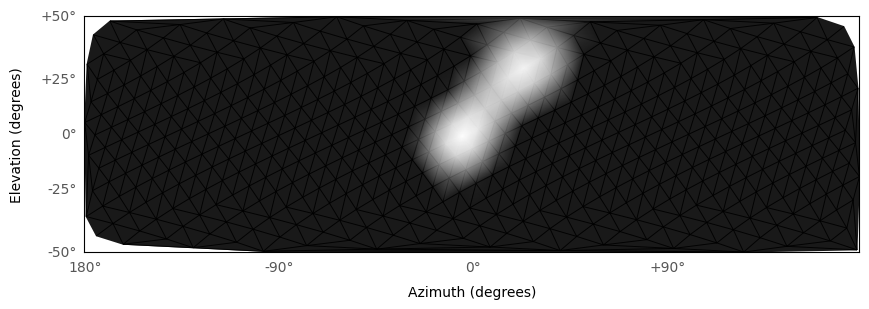

In [146]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
arg_lonticks = np.linspace(-180, 180, 5)
apgd_map = np.abs(I_apgd['sol'])
apgd_map /= apgd_map.max()
apgd_map = np.tile(apgd_map, (3, 1))
fig2, ax2, triangulation2 = draw_map(apgd_map, R,
        lon_ticks=arg_lonticks,
        catalog=None,
        show_labels=True,
        show_axis=True,
        fig=fig,
        ax=ax,
        kmeans=False, 
        gaussian_mixture=False)